In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/PYSCSES')

from PYSCSES_source_code.defect_species import DefectSpecies
from PYSCSES_source_code.set_of_sites import Set_of_Sites
from PYSCSES_source_code.constants import boltzmann_eV
from PYSCSES_source_code.calculation import Calculation, calculate_activation_energies
from PYSCSES_source_code.set_up_calculation import calculate_grid_offsets
from PYSCSES_source_code.grid import Grid
from test_notebook import fig_params

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
boundary_conditions = 'periodic'
site_charges = False
systems = 'mott-schottky'
core_models = False
site_models = 'continuum'

In [3]:
alpha = 0.0005
conv = 1e-6
grid_x_min = -6.094e-9
grid_x_max = 5.16e-9
#bulk_x_min = -5.783e-9
bulk_x_min = -5e-9
bulk_x_max = -2.502e-9

dielectric = 55

index = 111
b = 7.65327e-10
c = 7.65327e-10

temp = [ 773.15 ]

In [4]:
valence = [ +2.0, -1.0 ]
site_labels = [ 'O', 'Ce' ]
defect_labels = ['Vo', 'Gd']
mole_fractions = np.array([ [ 0.05, 0.2 ] ])
initial_guess = np.array([ [ 0.05, 0.2 ] ])
mobilities = [ 1.0, 0.0 ]

In [5]:
data_3 = '/Users/glw33/source/PYSCSES/userguides/input_data/Gd_CeO2_111_data.txt'

In [6]:
limits, laplacian_limits = calculate_grid_offsets( data_3, grid_x_min, grid_x_max, 'single' )

for m in mole_fractions:
    for t in temp:
    
        defect_species = { l : DefectSpecies( l, v, m, mob ) for l, v, m, mob in zip( defect_labels, valence, m, mobilities ) }

        all_sites = Set_of_Sites.set_of_sites_from_input_data( data_3, [grid_x_min, grid_x_max], defect_species, site_charges, core_models, t )
        if site_models == 'continuum':
            all_sites = Set_of_Sites.form_continuum_sites_new( all_sites, grid_x_min, grid_x_max, 1000, b, c, defect_species, laplacian_limits, site_labels, defect_labels )
        if systems == 'mott-schottky':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = True
        if systems == 'gouy-chapman':
            for site in all_sites.subset( 'Ce' ):
                site.defect_with_label('Gd').fixed = False
        grid = Grid.grid_from_set_of_sites( all_sites, limits, laplacian_limits, b, c )
 
        c_o = Calculation( grid, bulk_x_min, bulk_x_max, alpha, conv, dielectric, t, boundary_conditions )
        c_o.form_subgrids( site_labels )
        if systems == 'gouy-chapman':
            c_o.mole_fraction_correction( m, systems, initial_guess )
        c_o.solve(systems)
        c_o.mole_fractions()
        c_o.calculate_resistivity_ratio( 'positive', 2e-2 )
        c_o.solve_MS_approx_for_phi( valence[0] )

print(c_o.ms_phi)

0.0007420103961086874
4.7849495517038794e-05
6.450185951718764e-06
1.1479238100613006e-06
0.749448092247369


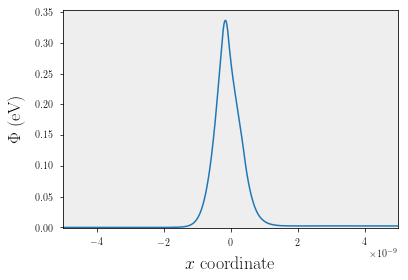

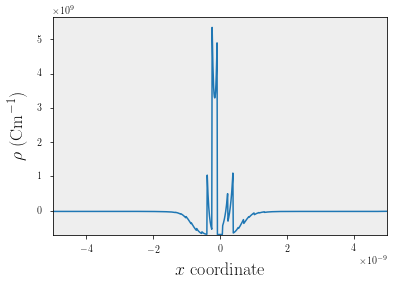

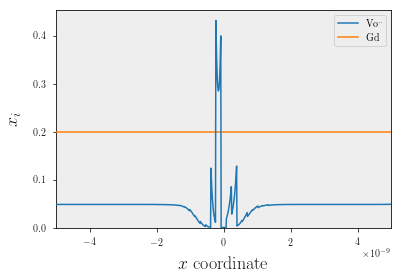

In [7]:
# from fig_params import rcParams
# import fig_params as fp
# rcParams.update( fp.transitionfig_formatting)
plt.plot(grid.x, c_o.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )
plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(min(c_o.phi))
plt.show()

plt.plot(grid.x, c_o.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $ \\rho $ $(\mathrm{C m}^{-1})$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(min(c_o.rho))
plt.show()

plt.plot(grid.x, c_o.mf[site_labels[0]], label = '$\mathrm{Vo}^{..}$', zorder = 5.0)
plt.plot(grid.x, c_o.mf[site_labels[1]], label = '$\mathrm{Gd}$', zorder = 4.0)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.xlim( -5e-9, 5e-9)
plt.ylim(0.0)
plt.legend()
plt.show()

In [8]:
print('perpendicular_resistivity_ratio=', c_o.perpendicular_resistivity_ratio)
print('parallel_resistivity_ratio =', c_o.parallel_resistivity_ratio)

perpendicular_resistivity_ratio= 131036689.77389431
parallel_resistivity_ratio = 3.77070699232324e-05
